# Details about the SIR Model

In [1]:
# Details about SIR model
# dS/dt = -bSI/(S+I+R)
# dI/dt = bSI/(S+I+R) - gI
# dR/dt = gI
# g = rate of removal
# b = number of cases caused by 1 infected individual in unit time
# S = number of susceptible people
# I = number of infected people
# R = number of removed people(recovered + dead)
# r0 = b*(1/g)
#s-ward population = 7,43,259
#s-ward proportion = 0.00715

# Plotting the Data

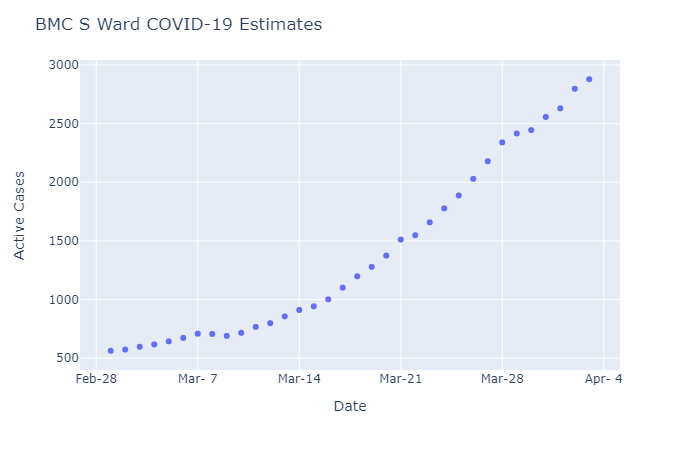

In [2]:
#libraries required for plotting data and calculus
import numpy as np
import scipy.integrate as spi 
import plotly.express as px
import pandas as pd
#reading data from the data file
df = pd.read_csv("maha_covid.csv")
#taking only data from march 1st to april 3rd
df = df[59:-7]
df = df.reset_index(drop=True)
#multiplying the proportion of s ward covid cases to the cases of maharashtra
df["Confirmed"] = 0.00715*df["Confirmed"]
df["Recovered"] = 0.00715*df["Recovered"]
df["Deaths"] = 0.00715*df["Deaths"]
df["Active"] = 0.00715*df["Active"]
#plotting the data
fig = px.scatter(df,x="Date",y="Active")
fig.update_layout(
    height=550,
    width=1000,
    xaxis=dict(tickformat="%b-%e"),
    xaxis_title="Date",
    yaxis_title="Active Cases",
    title = "BMC S Ward COVID-19 Estimates"
)
fig.show("png")

# Building the SIR Model

In [3]:
#storing values of population,susceptible,infected and removed in variables
N = 743259
I0 = df.Active[0]
R0 = df.Recovered[0]+df.Deaths[0]
S0 = N - (I0+R0)
#storing them all as a vector
vec = np.array([S0,I0,R0])
#derivative of the vector
def f(v,t0,beta,gamma):
    s,i,r = v
    sdot = -(beta*s*i/N)
    idot = (beta*s*i/N)-(gamma*i)
    rdot = (gamma*r)
    return np.r_[sdot,idot,rdot]
#initial guess of beta and gamma
b = 0.03
g = 0.006
#timeframe in days
t = np.linspace(0,33,34)
#simulating the differential equations
v = spi.odeint(f,vec,t,args=(b,g))
#printing the last 14 values of the result of the initial guess
print(v[20:])

[[727382.50832151    899.38366038  16789.43192765]
 [727355.792832      920.63932856  16890.47133432]
 [727328.44699098    942.39631616  16992.11879978]
 [727300.45598037    964.66639808  17094.37798336]
 [727271.80463667    987.4616232   17197.25256639]
 [727242.477443     1010.79432071  17300.74625236]
 [727212.45851722   1034.67710947  17404.86276709]
 [727181.7316103    1059.12289931  17509.60585878]
 [727150.28009657   1084.14489875  17614.97929818]
 [727118.08696538   1109.7566216   17720.98687874]
 [727085.13481235   1135.97189383  17827.6324167 ]
 [727051.40582087   1162.80486814  17934.91975133]
 [727016.88175913   1190.27002636  18042.85274498]
 [726981.5439718    1218.38218601  18151.43528328]]


# Optimizing the paramters

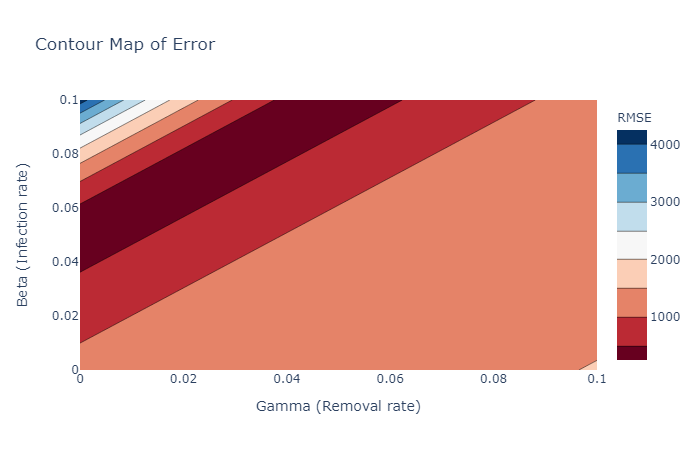

In [4]:
#library for plotting contour
import plotly.graph_objects as go 
#function that returns the root mean square error the model
def rmse(y_true,y_pred):
    assert len(y_true) == len(y_pred)
    m = len(y_true)
    error = (y_true-y_pred)**2
    return np.sqrt(np.sum(error)/m)
#range of values of beta and gamma for trial and error
beta_range = np.linspace(0,0.1,50)
gamma_range = np.linspace(0,0.1,50)
#storing the values of trial in a list
z = []
for i in beta_range:
    for j in gamma_range:
        y = spi.odeint(f,vec,t,args=(i,j))[:,1]
        z.append(rmse(df.Active,y))
z = np.array([z])
z = z.reshape(50,50)
#drawing a contour figure where the x axis represents gamma, y axis represents beta and the value of the contour is the rmse
rmse_fig = go.Figure(data=[
    go.Contour(
        x = gamma_range,
        y = beta_range,
        z = z,
        colorscale='RdBu',
        colorbar_title = "RMSE",
        line_smoothing = 0,
    )
])
rmse_fig.update_layout(
    height=550,
    width=1000,
    xaxis_title="Gamma (Removal rate)",
    yaxis_title="Beta (Infection rate)",
    title = "Contour Map of Error"
)
rmse_fig.show("png")
# the dark red part of the contour shows the region of the lowest error
# from there I did trial and error to find the values of beta and gamma that give lowest error
# the values of beta and gamma were calculated depending on the cases from 1st March to 3rd April 2021

# Final Guess and R0 calculation

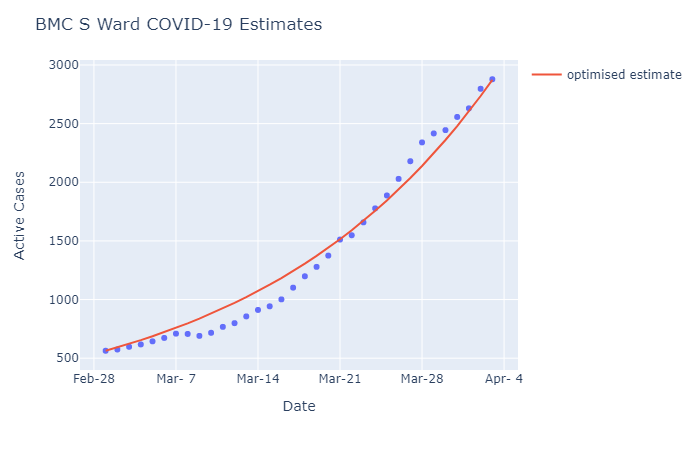

In [5]:
#storing final values of beta and gamma in variables
b_f = 0.07760
g_f = 0.02649
#selecting only the infected values from the vector
y_final = spi.odeint(f,vec,t,args=(b_f,g_f))[:,1]
#adding the optimized estimate to the figure
fig.add_trace(go.Scatter(
    x = df.Date,
    y = y_final,
    mode='lines',
    name="optimised estimate"
))
fig.show("png")
# the blue markers are the number of active cases from 1st March to 3rd April 2021

In [6]:
#Printing the root mean square error of our estimatee
print(rmse(df.Active,y_final))

108.96970657220527


In [7]:
#Printing the R value 
Re = b_f/g_f
print(Re)

2.929407323518309


## Estimated R (Effective Reproductive Number) = 2.929407323518309 ~ 2.93

# Testing accuracy 

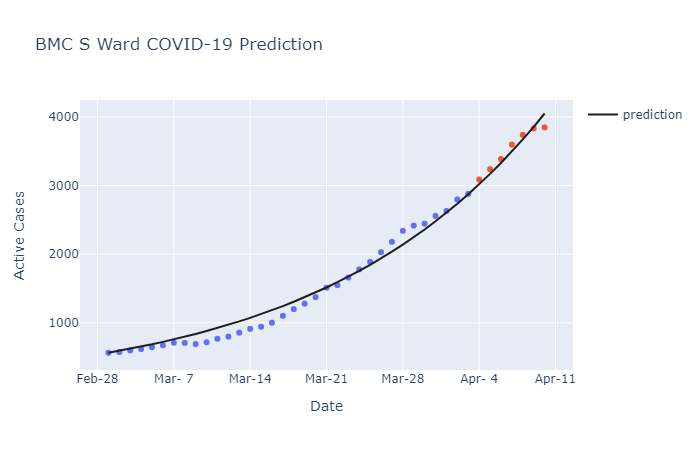

In [8]:
#reading data from the file
pred_df = pd.read_csv("maha_covid.csv")
#taking all dates from march 1st to april 10th
pred_df = pred_df[59:]
pred_df = pred_df.reset_index(drop=True)
pred_df["Confirmed"] = 0.00715*pred_df["Confirmed"]
pred_df["Recovered"] = 0.00715*pred_df["Recovered"]
pred_df["Deaths"] = 0.00715*pred_df["Deaths"]
pred_df["Active"] = 0.00715*pred_df["Active"]
#building a prediction figure
pred_fig = go.Figure()
#adding data of 1st March to 3rd April
pred_fig.add_trace(go.Scatter(
    x = df["Date"],
    y = df["Active"],
    mode="markers",
    showlegend=False
))
#adding data of 4th April to 10th April
pred_fig.add_trace(go.Scatter(
    x = pred_df["Date"][-7:],
    y = pred_df["Active"][-7:],
    mode="markers",
    showlegend=False,
))
#simulating the differential equations from March 3rd to April 10th
time = np.linspace(0,40,41)
y_pred = spi.odeint(f,vec,time,args=(b_f,g_f))[:,1]
#adding line of prediction
pred_fig.add_trace(go.Scatter(
    x = pred_df.Date,
    y = y_pred,
    mode='lines',
    name="prediction",
    marker_color='rgb(30,30,30)'
))
pred_fig.update_layout(
    height=550,
    width=1000,
    xaxis=dict(tickformat="%b-%e"),
    xaxis_title="Date",
    yaxis_title="Active Cases",
    title = "BMC S Ward COVID-19 Prediction"
)
pred_fig.show("png")
# the blue markers are the number of active cases from 1st March to 3rd April 2021
# the black line is the prediction made beforehand starting from 1st March to 10th April 2021
# the red markers are the actual number of active cases from 3rd April to 10th April

In [9]:
final_stats = pred_df.tail(1)
#finding proportion of susceptible persons in the total population
s = 1 - (final_stats.Confirmed.iat[0]/N)
#calculating r0
R0 = Re/s
print(f"R0 = {R0}")
print(f"Proportion of susceptible persons in the population = {s}")

R0 = 3.026772938770778
Proportion of susceptible persons in the population = 0.9678318733442851


## Estimated R0 (Basic Reproductive Number) = 3.026772938770778 ~ 3.027